# Quick Start With Public Datasets and add new Dataset

In this tutorial, we introduce how to quickly set up workflows with MONAI public Datasets and how to add new Dataset.  
Currently, MONAI provides `MedNISTDataset` and `DecathlonDataset` to automatically download and extract  
the MedNIST and Decathlon datasets, and act as PyTorch datasets to generate training/validation/test data. 

We'll cover the following topics in this tutorial:
* Create training experiment with MedNISTDataset and workflow
* Create training experiment with DecathlonDataset and workflow
* Share other public data and add Dataset in MONAI

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/MONAI/blob/master/examples/notebooks/public_datasets.ipynb)

## Setup environment

In [1]:
%pip install -qU "monai[gdown, nibabel, ignite]"

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install -qU matplotlib
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


## Setup imports

In [1]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import logging
import os
import shutil
import sys
import tempfile

import ignite
import matplotlib.pyplot as plt
import torch

from monai.apps import DecathlonDataset, MedNISTDataset, download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.engines import SupervisedTrainer
from monai.handlers import MeanDice, StatsHandler
from monai.inferers import SimpleInferer
from monai.losses import DiceLoss
from monai.networks.layers import Norm
from monai.networks.nets import UNet, densenet121
from monai.transforms import (
    AddChanneld,
    AsDiscreted,
    Compose,
    LoadNiftid,
    LoadPNGd,
    Orientationd,
    Randomizable,
    Resized,
    ScaleIntensityd,
    Spacingd,
    ToTensord,
)

print_config()

MONAI version: 0.2.0
Python version: 3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31)  [GCC 7.3.0]
Numpy version: 1.18.1
Pytorch version: 1.6.0

Optional dependencies:
Pytorch Ignite version: 0.3.0
Nibabel version: 3.1.1
scikit-image version: 0.15.0
Pillow version: 7.0.0
Tensorboard version: 2.1.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the MONAI_DATA_DIRECTORY environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [2]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/workspace/data/medical


## Setup logging

In [3]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

## Create training experiment with MedNISTDataset and workflow

The MedNIST dataset was gathered from several sets from [TCIA](https://wiki.cancerimagingarchive.net/display/Public/Data+Usage+Policies+and+Restrictions), [the RSNA Bone Age Challenge](http://rsnachallenges.cloudapp.net/competitions/4), and [the NIH Chest X-ray dataset](https://cloud.google.com/healthcare/docs/resources/public-datasets/nih-chest).

### Set up pre-processing transforms

In [4]:
transform = Compose(
    [
        LoadPNGd(keys="image"),
        AddChanneld(keys="image"),
        ScaleIntensityd(keys="image"),
        ToTensord(keys="image"),
    ]
)

### Create MedNISTDataset for training
`MedNISTDataset` inherits from MONAI `CacheDataset` and provides rich parameters to achieve expected behavior:
1. **root_dir**: target directory to download and load MedNIST dataset.
1. **section**: expected data section, can be: `training`, `validation` or `test`.
1. **transform**: transforms to execute operations on input data. the default transform is composed by `LoadPNGd` and `AddChanneld`, which can load data into numpy array with [C, H, W] shape.
1. **download**: whether to download and extract the MedNIST from resource link, default is False. if expected file already exists, skip downloading even set it to True. user can manually copy `MedNIST.tar.gz` file or `MedNIST` folder to root directory.
1. **seed**: random seed to randomly split training, validation and test datasets, defaut is 0.
1. **val_frac**: percentage of of validation fraction in the whole dataset, default is 0.1.
1. **test_frac**: percentage of of test fraction in the whole dataset, default is 0.1.
1. **cache_num**: number of items to be cached. Default is `sys.maxsize`. will take the minimum of (cache_num, data_length x cache_rate, data_length).
1. **cache_rate**: percentage of cached data in total, default is 1.0 (cache all). will take the minimum of (cache_num, data_length x cache_rate, data_length).
1. **num_workers**: the number of worker threads to use. If 0 a single thread will be used. Default is 0.

Note that the "tar files" are cached after a first time downloading. the `self.__getitem__()` API generates 1 `{"image": XXX, "label": XXX}` dict according to the specified index within the `self.__len__()`.

In [5]:
train_ds = MedNISTDataset(root_dir=root_dir, transform=transform, section="training", download=True)
# the dataset can work seamlessly with the pytorch native dataset loader,
# but using monai.data.DataLoader has additional benefits of mutli-process
# random seeds handling, and the customized collate functions
train_loader = DataLoader(train_ds, batch_size=300, shuffle=True, num_workers=10)

61841408/61834679 Downloading MedNIST.tar.gz: [==============================]
downloaded file: /workspace/data/medical/MedNIST.tar.gz.
46946/46946 Load and cache transformed data:  [==============================]


### Pick images from MedNISTDataset to visualize and check

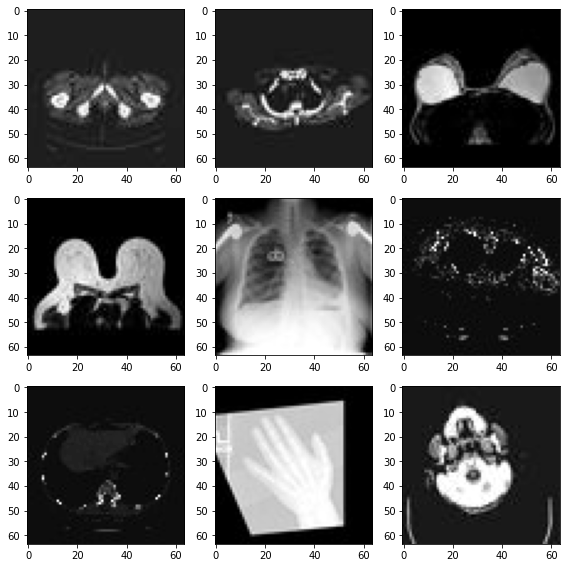

In [6]:
plt.subplots(3, 3, figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_ds[i * 5000]["image"][0].detach().cpu(), cmap="gray")
plt.tight_layout()
plt.show()

### Create training components

In [7]:
device = torch.device("cuda:0")
net = densenet121(spatial_dims=2, in_channels=1, out_channels=6).to(device)
loss = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(net.parameters(), 1e-5)

### Define the easiest training workflow and run

Use MONAI SupervisedTrainer handlers to quickly set up a training workflow.

In [10]:
trainer = SupervisedTrainer(
    device=device,
    max_epochs=5,
    train_data_loader=train_loader,
    network=net,
    optimizer=opt,
    loss_function=loss,
    inferer=SimpleInferer(),
    key_train_metric={
        "train_acc": ignite.metrics.Accuracy(output_transform=lambda x: (x["pred"], x["label"]))
    },
    train_handlers=StatsHandler(tag_name="train_loss", output_transform=lambda x: x["loss"]),
)
trainer.run()

## Create training experiment with DecathlonDataset and workflow

The Decathlon dataset came from [Medical Segmentation Decathlon](http://medicaldecathlon.com/) AI challenge.

### Set up pre-processing transforms

In [4]:
transform = Compose(
    [
        LoadNiftid(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityd(keys="image"),
        Resized(keys=["image", "label"], spatial_size=(32, 64, 32), mode=("trilinear", "nearest")),
        ToTensord(keys=["image", "label"]),
    ]
)

### Create DeccathlonDataset for training

`DecathlonDataset` inherits from MONAI `CacheDataset` and provides rich parameters to achieve expected behavior:
1. **root_dir**: user's local directory for caching and loading the MSD datasets.
1. **task**: which task to download and execute: one of list ("Task01_BrainTumour", "Task02_Heart", "Task03_Liver", "Task04_Hippocampus", "Task05_Prostate", "Task06_Lung", "Task07_Pancreas", "Task08_HepaticVessel", "Task09_Spleen", "Task10_Colon").
1. **section**: expected data section, can be: `training`, `validation` or `test`.
1. **transform**: transforms to execute operations on input data. the default transform is composed by `LoadNiftid` and `AddChanneld`, which can load data into numpy array with [C, H, W, D] shape.
1. **download**: whether to download and extract the Decathlon from resource link, default is False. if expected file already exists, skip downloading even set it to True. user can manually copy tar file or dataset folder to the root directory.
1. **seed**: random seed to randomly split `training`, `validation` and `test` datasets, defaut is 0.
1. **val_frac**: percentage of of validation fraction from the `training` section, default is 0.2. Decathlon data only contains `training` section with labels and `test` section without labels, so randomly select fraction from the `training` section as the `validation` section.
1. **cache_num**: number of items to be cached. Default is `sys.maxsize`. will take the minimum of (cache_num, data_length x cache_rate, data_length).
1. **cache_rate**: percentage of cached data in total, default is 1.0 (cache all). will take the minimum of (cache_num, data_length x cache_rate, data_length).
1. **num_workers**: the number of worker threads to use. if 0 a single thread will be used. Default is 0.

Note that the "tar files" are cached after a first time downloading. the `self.__getitem__()` API generates 1 `{"image": XXX, "label": XXX}` dict according to the specified index within the `self.__len__()`.

In [6]:
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task04_Hippocampus",
    transform=transform,
    section="training",
    download=True,
)
# the dataset can work seamlessly with the pytorch native dataset loader,
# but using monai.data.DataLoader has additional benefits of mutli-process
# random seeds handling, and the customized collate functions
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=16)

28426240/28425216 Downloading Task04_Hippocampus.tar: [==============================]
downloaded file: /workspace/data/medical/Task04_Hippocampus.tar.
208/208 Load and cache transformed data:  [==============================]


### Pick images from DecathlonDataset to visualize and check

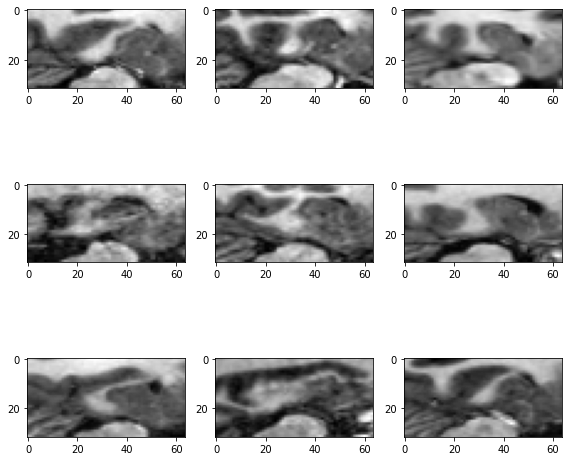

In [7]:
plt.subplots(3, 3, figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_ds[i * 20]["image"][0, :, :, 10].detach().cpu(), cmap="gray")
plt.tight_layout()
plt.show()

### Create training components

In [14]:
device = torch.device("cuda:0")
net = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=3,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss = DiceLoss(to_onehot_y=True, softmax=True)
opt = torch.optim.Adam(net.parameters(), 1e-2)

### Define the easiest training workflow and run
Use MONAI SupervisedTrainer handlers to quickly set up a training workflow.

In [15]:
trainer = SupervisedTrainer(
    device=device,
    max_epochs=5,
    train_data_loader=train_loader,
    network=net,
    optimizer=opt,
    loss_function=loss,
    inferer=SimpleInferer(),
    post_transform=AsDiscreted(
        keys=["pred", "label"], argmax=(True, False), to_onehot=True, n_classes=3,
    ),
    key_train_metric={
        "train_meandice": MeanDice(output_transform=lambda x: (x["pred"], x["label"]))
    },
    train_handlers=StatsHandler(tag_name="train_loss", output_transform=lambda x: x["loss"]),
)
trainer.run()

## Share other public data and add Dataset in MONAI

Referring to the `MedNISTDataset` or `DecathlonDataset`, it's easy to create a new Dataset fo other public data.  
Mainly include below steps:
1. Inherit MONAI `CacheDataset` to leverage caching mechanism to accelerate training.
1. Make sure the license of dataset allows public access and share.
1. Use `monai.apps.download_and_extract` to download and extract data in the Dataset.
1. Define the logic to randomly split `training`, `validation` and `test` sections.
1. Construct data list with `dict` items:
```py
[
    {'image': image1_path, 'label': label1_path},
    {'image': image2_path, 'label': label2_path},
    {'image': image3_path, 'label': label3_path},
    ... ...
]
```
1. Define dataset specific logic.

### Define IXIDataset as an example

Here we use the [IXI Dataset](https://brain-development.org/ixi-dataset/) as an example to show how to create a new `IXIDataset`.

In [10]:
class IXIDataset(Randomizable, CacheDataset):
    resource = "http://biomedic.doc.ic.ac.uk/brain-development/downloads/IXI/IXI-T1.tar"
    md5 = "34901a0593b41dd19c1a1f746eac2d58"

    def __init__(
        self,
        root_dir,
        section,
        transform,
        download=False,
        seed=0,
        val_frac=0.2,
        test_frac=0.2,
        cache_num=sys.maxsize,
        cache_rate=1.0,
        num_workers=0,
    ):
        if not os.path.isdir(root_dir):
            raise ValueError("Root directory root_dir must be a directory.")
        self.section = section
        self.val_frac = val_frac
        self.test_frac = test_frac
        self.set_random_state(seed=seed)
        dataset_dir = os.path.join(root_dir, "ixi")
        tarfile_name = f"{dataset_dir}.tar"
        if download:
            download_and_extract(self.resource, tarfile_name, dataset_dir, self.md5)
        # as a quick demo, we just use 10 images to show
        
        
        
        self.datalist = [
            {"image": os.path.join(dataset_dir, "IXI314-IOP-0889-T1.nii.gz"), "label": 0},
            {"image": os.path.join(dataset_dir, "IXI249-Guys-1072-T1.nii.gz"), "label": 0},
            {"image": os.path.join(dataset_dir, "IXI609-HH-2600-T1.nii.gz"), "label": 0},
            {"image": os.path.join(dataset_dir, "IXI173-HH-1590-T1.nii.gz"), "label": 1},
            {"image": os.path.join(dataset_dir, "IXI020-Guys-0700-T1.nii.gz"), "label": 0},
            {"image": os.path.join(dataset_dir, "IXI342-Guys-0909-T1.nii.gz"), "label": 0},
            {"image": os.path.join(dataset_dir, "IXI134-Guys-0780-T1.nii.gz"), "label": 0},
            {"image": os.path.join(dataset_dir, "IXI577-HH-2661-T1.nii.gz"), "label": 1},
            {"image": os.path.join(dataset_dir, "IXI066-Guys-0731-T1.nii.gz"), "label": 1},
            {"image": os.path.join(dataset_dir, "IXI130-HH-1528-T1.nii.gz"), "label": 0},
        ]
        data = self._generate_data_list()
        super().__init__(
            data, transform, cache_num=cache_num, cache_rate=cache_rate, num_workers=num_workers,
        )

    def randomize(self, data=None):
        self.rann = self.R.random()

    def _generate_data_list(self):
        data = list()
        for d in self.datalist:
            self.randomize()
            if self.section == "training":
                if self.rann < self.val_frac + self.test_frac:
                    continue
            elif self.section == "validation":
                if self.rann >= self.val_frac:
                    continue
            elif self.section == "test":
                if self.rann < self.val_frac or self.rann >= self.val_frac + self.test_frac:
                    continue
            else:
                raise ValueError(
                    f"Unsupported section: {self.section}, "
                    "available options are ['training', 'validation', 'test']."
                )
            data.append(d)
        return data

### Pick images from IXIDataset to visualize and check

4840816640/4840816640 Downloading ixi.tar: [==============================]

downloaded file: /workspace/data/medical/ixi.tar.
9/9 Load and cache transformed data:  [==============================]


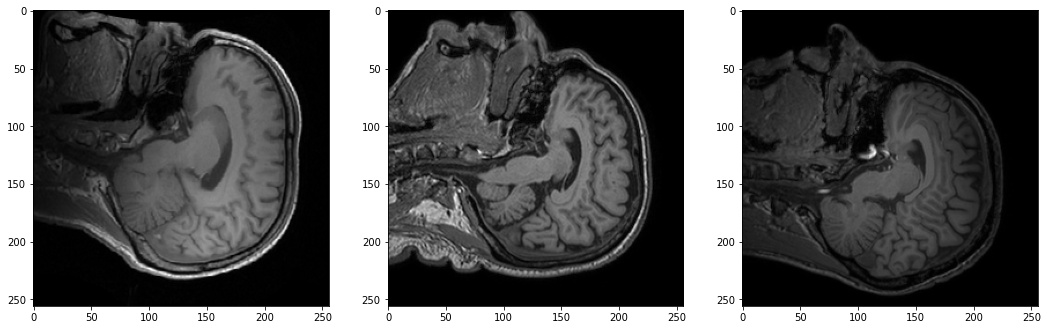

In [11]:
train_ds = IXIDataset(
    root_dir=root_dir,
    section="training",
    transform=Compose([LoadNiftid("image"), ToTensord("image")]),
    download=True,
)
plt.figure("check", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(train_ds[i]["image"][:, :, 80].detach().cpu(), cmap="gray")
plt.show()

## Cleanup data directory

Remove directory if a temporary was used.

In [18]:
if directory is None:
    shutil.rmtree(root_dir)